In [1]:
!python --version

Python 3.10.13


In [2]:
import keras as ks
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import time
from keras.datasets import cifar10
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

In [3]:
ks.__version__

'2.14.0'

In [4]:
tf.__version__

'2.14.0'

In [5]:
IMG_SIZE = 32
SUB_IMG_SIZE = 256
SLEEP_TIME = 1

In [6]:
# LOADING THE CAT DETECTION CNN MODEL
model = ks.models.load_model('CNN_CIFAR_10.keras')

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

In [9]:
def process_image(image):
    image = ks.preprocessing.image.img_to_array(image)/255.0
    image = np.expand_dims(image, axis = 0)
    return image

In [10]:
def get_one_frame():
    SELECTED_FRAME = 60
    FRAMES = 0
    try:
        video_capture = cv2.VideoCapture(0) # turn the webcam on.
        gray = None
        frame = None
        while True:
            _, frame = video_capture.read() # get the last frame.
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # color transformations.
            # cv2.imshow('Video', gray) # We display the outputs.
            FRAMES += 1
            if FRAMES >= SELECTED_FRAME:
                break
        video_capture.release() # turn the webcam off
        cv2.destroyAllWindows() # destroy all the windows inside which the images were displayed.
        return frame, gray
    except Exception as e:
        print('Exception, ', e)
    finally:
        # canvas = detect(gray, frame) # output of detect function.
        video_capture.release() # turn the webcam off
        cv2.destroyAllWindows() # destroy all the windows inside which the images were displayed.

In [11]:
def show_predictions_on_frame(frame, ):
    # ADDING RECTANGLES
    H_LOOPS = int(np.ceil(frame.shape[1]/SUB_IMG_SIZE))
    V_LOOPS = int(np.ceil(frame.shape[0]/SUB_IMG_SIZE))

    # Create figure and axes
    fig, ax = plt.subplots()
    FRAME_NO = 0
    # Display the image
    ax.imshow(frame)
    print('IMAGE SHAPE: ', frame.shape)
    for h in range(H_LOOPS):
        for v in range(V_LOOPS):
            FRAME_NO += 1
            temp_frame = frame[v*SUB_IMG_SIZE:v*SUB_IMG_SIZE+SUB_IMG_SIZE, h*SUB_IMG_SIZE:h*SUB_IMG_SIZE+SUB_IMG_SIZE]/255
            temp_frame_resized = np.expand_dims(cv2.resize(temp_frame, dsize=(IMG_SIZE, IMG_SIZE)), axis=0)
            prediction = round(model.predict(temp_frame_resized)[0][3] * 100, 3)
            rect = patches.Rectangle((h*SUB_IMG_SIZE, v*SUB_IMG_SIZE), SUB_IMG_SIZE, SUB_IMG_SIZE, linewidth=1, edgecolor='r', facecolor='none')
            ax.annotate(prediction, (h*SUB_IMG_SIZE+(SUB_IMG_SIZE/2), v*SUB_IMG_SIZE+(SUB_IMG_SIZE/2)), color='g' if prediction < 10 else 'r', weight='bold', fontsize=10, ha='center', va='center')
            ax.add_patch(rect)
    plt.show()

In [12]:
def show_predictions_on_live(frame, ):
    # ADDING RECTANGLES
    H_LOOPS = int(np.ceil(frame.shape[1]/SUB_IMG_SIZE))
    V_LOOPS = int(np.ceil(frame.shape[0]/SUB_IMG_SIZE))

    for h in range(H_LOOPS):
        for v in range(V_LOOPS):
            temp_frame = frame[v*SUB_IMG_SIZE:v*SUB_IMG_SIZE+SUB_IMG_SIZE, h*SUB_IMG_SIZE:h*SUB_IMG_SIZE+SUB_IMG_SIZE]/255
            temp_frame_resized = np.expand_dims(cv2.resize(temp_frame, dsize=(IMG_SIZE, IMG_SIZE)), axis=0)
            prediction = str(round(model.predict(temp_frame_resized)[0][3] * 100, 3))
            rect = cv2.rectangle(frame, (h*SUB_IMG_SIZE, v*SUB_IMG_SIZE), (h*SUB_IMG_SIZE+SUB_IMG_SIZE, v*SUB_IMG_SIZE+SUB_IMG_SIZE), (50,205,50) if float(prediction) >= 90 else (255,69,0), 2) # We paint a rectangle around the face..Rectangle((h*SUB_IMG_SIZE, v*SUB_IMG_SIZE), SUB_IMG_SIZE, SUB_IMG_SIZE, linewidth=1, edgecolor='r', facecolor='none')
            
            text = cv2.putText(rect, prediction, (h*SUB_IMG_SIZE+SUB_IMG_SIZE//2, v*SUB_IMG_SIZE+SUB_IMG_SIZE//2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (50,205,50) if float(prediction) >= 90 else (255, 69, 0), 2)
            # ax.annotate(prediction, (h*SUB_IMG_SIZE+(SUB_IMG_SIZE/2), v*SUB_IMG_SIZE+(SUB_IMG_SIZE/2)), color='g' if prediction < 10 else 'r', weight='bold', fontsize=10, ha='center', va='center')
            # ax.add_patch(rect)
    return frame

In [13]:
def get_live_predictions():
    video_capture = cv2.VideoCapture(0) # We turn the webcam on.
    while True: # We repeat infinitely (until break):
        _, frame = video_capture.read() # We get the last frame.q
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # We do some colour transformations.
        canvas = show_predictions_on_live(frame) # We get the output of our detect function.
        cv2.imshow('Video', canvas) # We display the outputs.
        if cv2.waitKey(1) & 0xFF == ord('q'): # If we type on the keyboard:
            break # We stop the loop.
    
    video_capture.release() # We turn the webcam off.
    cv2.destroyAllWindows() # We destroy all the windows inside which the images were displayed.

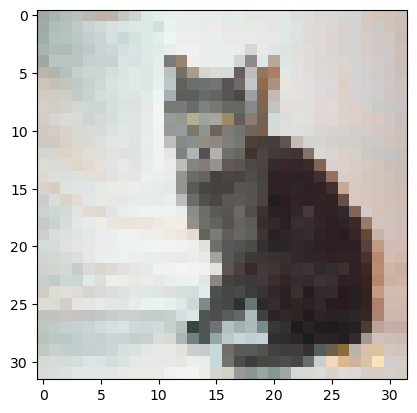

In [14]:
# TEST THE MODEL ON A CAT IMAGE
test_image = ks.preprocessing.image.load_img('cat.4014.jpg', target_size = (IMG_SIZE, IMG_SIZE))
plt.imshow(test_image)

In [15]:
test_image_array = process_image(test_image)

In [16]:
(model.predict(test_image_array))[0][3] > 0.5   #[0][0] > 0.5

1/1 [==============================] - 1s 612ms/step


True

In [17]:
# WORKING ON THE CV PART
# IMAGE HEIGHT = 480px, WIDTH = 640px

In [18]:
video_capture = cv2.VideoCapture(0) # turn the webcam on.
while True: # repeat infinitely (until break):
    _, frame = video_capture.read() # get the last frame.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # color transformations.
    # canvas = detect(gray, frame) # output of detect function.
    cv2.imshow('Video', gray) # We display the outputs.
    time.sleep(SLEEP_TIME)
    if cv2.waitKey(1) & 0xFF == ord('q'): # keyboard:
        break # stop the loop.

video_capture.release() # turn the webcam off
cv2.destroyAllWindows() # destroy all the windows inside which the images were displayed.

In [19]:
test_one_frame, test_one_gray = get_one_frame()

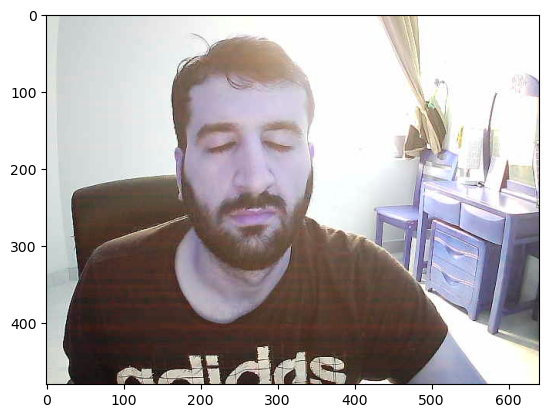

In [20]:
plt.imshow(test_one_frame)

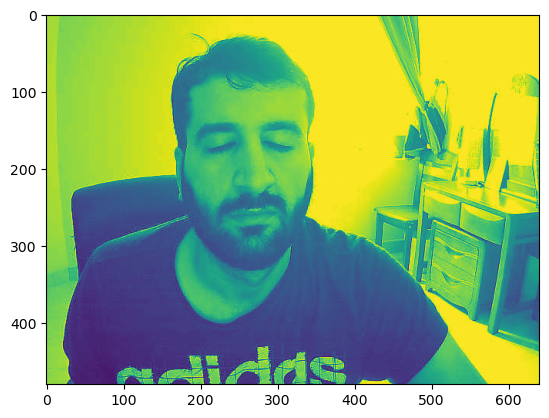

In [21]:
plt.imshow(test_one_gray)

IMAGE SHAPE:  (480, 640, 3)
1/1 [==============================] - 0s 54ms/step


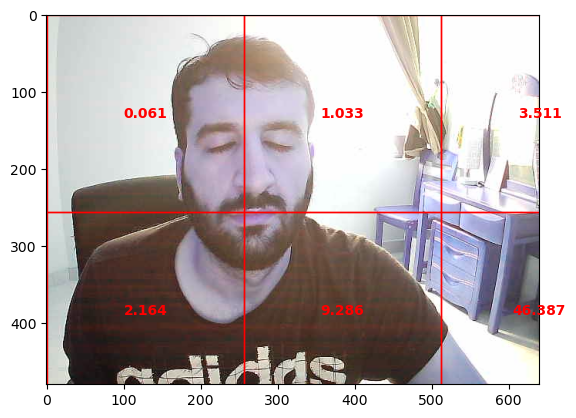

In [22]:
# ADDING RECTANGLES
H_LOOPS = int(np.ceil(test_one_frame.shape[1]/SUB_IMG_SIZE))
V_LOOPS = int(np.ceil(test_one_frame.shape[0]/SUB_IMG_SIZE))

# Create figure and axes
fig, ax = plt.subplots()
FRAME_NO = 0
# Display the image
ax.imshow(test_one_frame)
print('IMAGE SHAPE: ', test_one_frame.shape)
for h in range(H_LOOPS):
    for v in range(V_LOOPS):
        # rect = None
        # print('H: ', h*SUB_IMG_SIZE, ' | V: ', v*SUB_IMG_SIZE)
        # if h*SUB_IMG_SIZE+SUB_IMG_SIZE > test_one_frame.shape[1] and v*SUB_IMG_SIZE+SUB_IMG_SIZE > test_one_frame.shape[0]:
        #     print('SPECIAL CASE BOTH!')
        #     rect = patches.Rectangle((h*SUB_IMG_SIZE, v*SUB_IMG_SIZE), (h*SUB_IMG_SIZE)-SUB_IMG_SIZE-test_one_frame.shape[1], (v*SUB_IMG_SIZE)-SUB_IMG_SIZE-test_one_frame.shape[0], linewidth=1, edgecolor='r', facecolor='none')
        # elif h*SUB_IMG_SIZE+SUB_IMG_SIZE > test_one_frame.shape[1]:
        #     print('SPECIAL CASE H!')
        #     rect = patches.Rectangle((h*SUB_IMG_SIZE, v*SUB_IMG_SIZE), (h*SUB_IMG_SIZE)+SUB_IMG_SIZE-test_one_frame.shape[1], SUB_IMG_SIZE, linewidth=1, edgecolor='b', facecolor='none')
        # elif v*SUB_IMG_SIZE+SUB_IMG_SIZE > test_one_frame.shape[0]:
        #     print('SPECIAL CASE V!')
        #     rect = patches.Rectangle((h*SUB_IMG_SIZE, v*SUB_IMG_SIZE), SUB_IMG_SIZE, (v*SUB_IMG_SIZE)+SUB_IMG_SIZE-test_one_frame.shape[0], linewidth=1, edgecolor='y', facecolor='none')
        # else:
            # rect = patches.Rectangle((h*SUB_IMG_SIZE, v*SUB_IMG_SIZE), SUB_IMG_SIZE, SUB_IMG_SIZE, linewidth=1, edgecolor='g', facecolor='none')
        FRAME_NO += 1
        temp_frame = None
        try:
            temp_frame = test_one_frame[v*SUB_IMG_SIZE:v*SUB_IMG_SIZE+SUB_IMG_SIZE, h*SUB_IMG_SIZE:h*SUB_IMG_SIZE+SUB_IMG_SIZE]/255
        except InvalidArgumentError:
            print('Error at frame: ', FRAME_NO)
            temp_frame = test_one_frame[h*SUB_IMG_SIZE: , v*SUB_IMG_SIZE: ]/255
        # temp_frame_resized = np.expand_dims(tf.keras.preprocessing.image.smart_resize(temp_frame, (IMG_SIZE, IMG_SIZE)), axis = 0)
        temp_frame_resized = np.expand_dims(cv2.resize(temp_frame, dsize=(IMG_SIZE, IMG_SIZE)), axis=0)
        prediction = round(model.predict(temp_frame_resized)[0][3] * 100, 3)
        rect = patches.Rectangle((h*SUB_IMG_SIZE, v*SUB_IMG_SIZE), SUB_IMG_SIZE, SUB_IMG_SIZE, linewidth=1, edgecolor='r', facecolor='none')
        ax.annotate(prediction, (h*SUB_IMG_SIZE+(SUB_IMG_SIZE/2), v*SUB_IMG_SIZE+(SUB_IMG_SIZE/2)), color='g' if prediction > 50 else 'r', weight='bold', fontsize=10, ha='center', va='center')
        ax.add_patch(rect)
# Create a Rectangle patch
# rect = patches.Rectangle((0, 0), 64, 64, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)

plt.show()

IMAGE SHAPE:  (480, 640, 3)
1/1 [==============================] - 0s 53ms/step


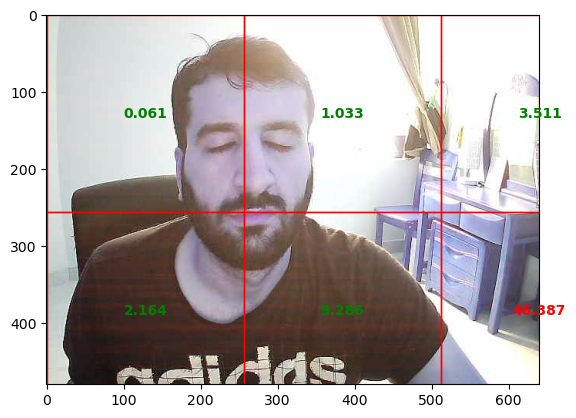

In [23]:
show_predictions_on_frame(frame=test_one_frame)

In [24]:
# USING CIFAR-10 CLASSIFICATION MODEL

In [25]:
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Cat Detector CNN.ipynb
./cat.4014.jpg
./CATS_vs_DOGS_CNN.keras
./CNN_CIFAR_10.keras
./IMG_3053.jpg
./model.png
./.ipynb_checkpoints\Cat Detector CNN-checkpoint.ipynb
./New folder\cifar-10-python.tar.gz
./New folder\data.pickle
./New folder\datasets_preparing.py
./New folder\get_CIFAR-10.sh
./New folder\labels.txt
./New folder\mean_and_std.pickle
./New folder\model_histories_ConvNet1_Overfitting.pickle
./New folder\model_histories_ConvNet1_Training.pickle
./New folder\model_params_ConvNet1.pickle
./New folder\cifar-10-batches-py\batches.meta
./New folder\cifar-10-batches-py\data_batch_1
./New folder\cifar-10-batches-py\data_batch_2
./New folder\cifar-10-batches-py\data_batch_3
./New folder\cifar-10-batches-py\data_batch_4
./New folder\cifar-10-batches-py\data_batch_5
./New folder\cifar-10-batches-py\readme.html
./New folder\cifar-10-batches-py\test_batch


In [26]:
# loading dateset
(x_train, y_train),(x_test,y_test) = cifar10.load_data()

In [27]:
# Checking loaded data 
print('Total number of Images in the Dataset:', len(x_train) + len(x_test))
print('Number of train images:', len(x_train))
print('Number of test images:', len(x_test))
print('Shape of training dataset:',x_train.shape)
print('Shape of testing dataset:',x_test.shape)

Total number of Images in the Dataset: 60000
Number of train images: 50000
Number of test images: 10000
Shape of training dataset: (50000, 32, 32, 3)
Shape of testing dataset: (10000, 32, 32, 3)


In [30]:
# This piece of code shows a random images and labels for given set of inputs 
def showImages(num_row,num_col,X,Y):
    import matplotlib.pyplot as plt
    %matplotlib inline

    from sklearn.utils import shuffle
    (X_rand, Y_rand) = shuffle(X, Y)
    
    fig, axes = plt.subplots(num_row,num_col,figsize = (12,12))
    axes = axes.ravel()
    for i in range(0, num_row*num_col):
        axes[i].imshow(X_rand[i])
        axes[i].set_title("{}".format(labels[Y_rand.item(i)]))
        axes[i].axis('off')
        plt.subplots_adjust(wspace =1)
        
    return

In [31]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

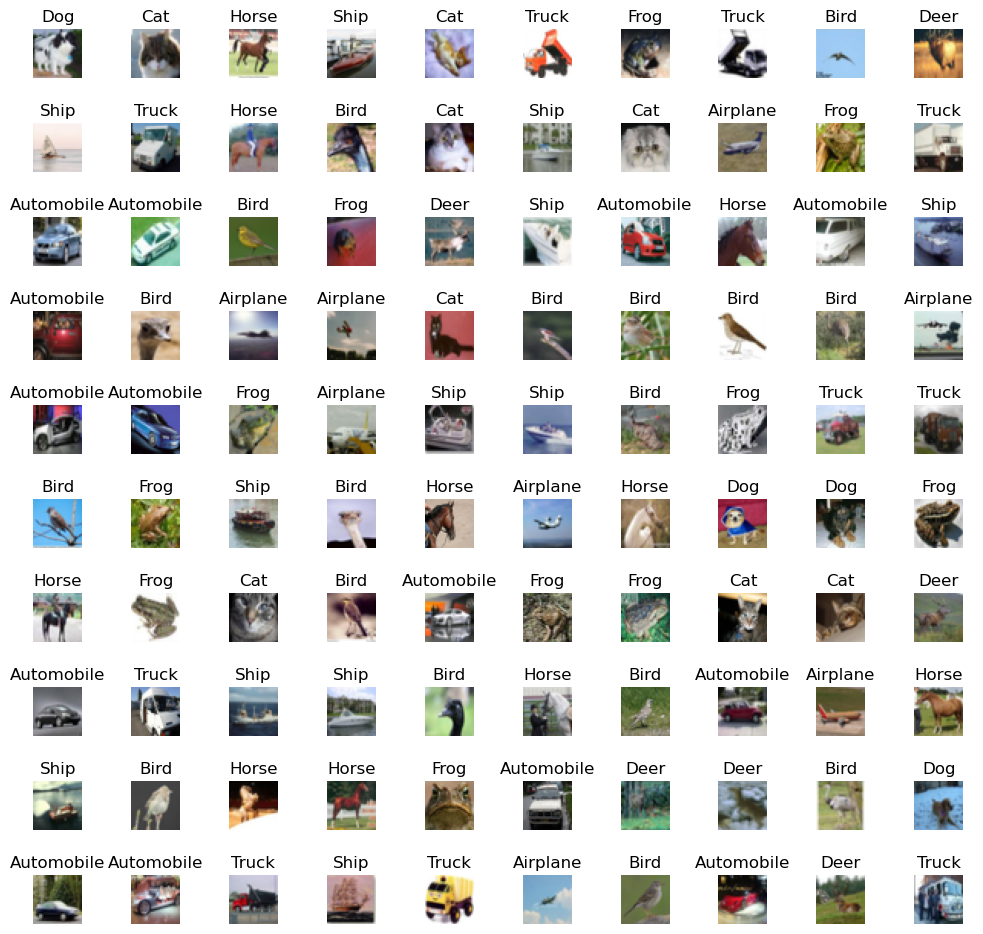

In [32]:
num_row = 10
num_col = 10
showImages(num_row,num_col,X =x_train,Y = y_train)

In [33]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/ 255
x_test = x_test/255

In [34]:
#keras.utils.to_cotegorical(y, num_of_classes) convert the label 
#data into (m, num_of class) array from (m, 1) input 

y_train_one_hot = ks.utils.to_categorical(y_train, 10) #as classes = 10
y_test_one_hot = ks.utils.to_categorical(y_test, 10)

In [35]:
print('The one hot label is: ', y_train_one_hot[1])
print(y_train_one_hot.shape)

The one hot label is:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
(50000, 10)


In [36]:
# #Building model computational graph
# model = Sequential()
# model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (32,32,3)))
# model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
# model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
# model.add(Dropout(0.3))
# model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
# model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))
# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(512, activation = 'relu'))
# model.add(Dropout(0.8))
# model.add(Dense(10, activation = 'softmax'))

'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

In [37]:
#Description about parameters and layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

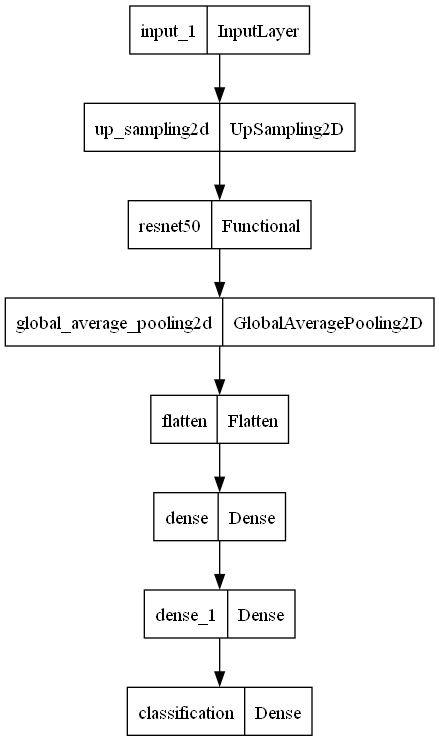

In [38]:
# Flow chart of the model 

ks.utils.plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [18]:
#compiling model with loss, opt, metrics
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate=0.0009,beta_1=0.9, beta_2=0.999,epsilon=1e-07)
metrics = ['accuracy']

model.compile(loss = loss, optimizer = opt, metrics = metrics)

In [19]:
# fitting the model for training dataset
hist = model.fit(x_train, y_train_one_hot, batch_size = 64 , epochs = 10, validation_split = 0.2)

Epoch 1/10
625/625 [==============================] - 4379s 7s/step - loss: 0.8243 - accuracy: 0.7180 - val_loss: 2.8894 - val_accuracy: 0.1480
Epoch 2/10
625/625 [==============================] - 4290s 7s/step - loss: 0.4532 - accuracy: 0.8457 - val_loss: 0.5885 - val_accuracy: 0.7981
Epoch 3/10
625/625 [==============================] - 4232s 7s/step - loss: 0.3289 - accuracy: 0.8874 - val_loss: 0.5843 - val_accuracy: 0.7992
Epoch 4/10
625/625 [==============================] - 4281s 7s/step - loss: 0.2384 - accuracy: 0.9188 - val_loss: 0.5142 - val_accuracy: 0.8417
Epoch 5/10
625/625 [==============================] - 4273s 7s/step - loss: 0.1910 - accuracy: 0.9338 - val_loss: 0.5449 - val_accuracy: 0.8415
Epoch 6/10
625/625 [==============================] - 4257s 7s/step - loss: 0.1499 - accuracy: 0.9486 - val_loss: 0.6351 - val_accuracy: 0.8080
Epoch 7/10
625/625 [==============================] - 4290s 7s/step - loss: 0.1190 - accuracy: 0.9590 - val_loss: 0.7247 - val_accuracy:

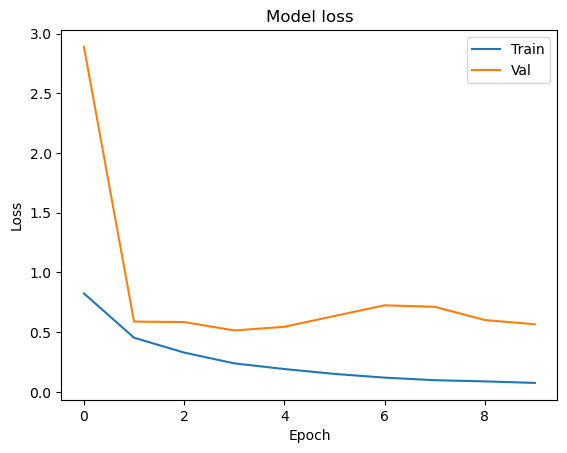

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

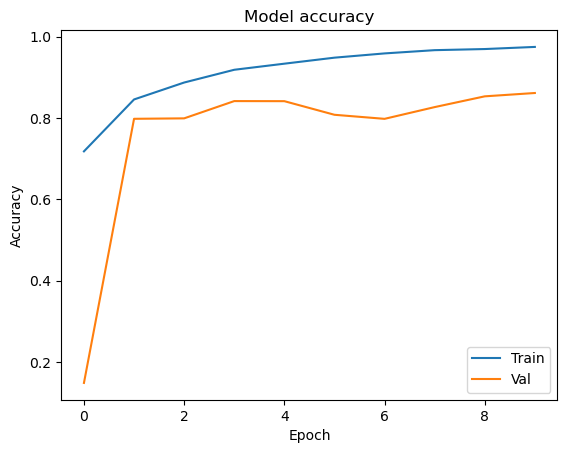

In [21]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [22]:
# EXPORTING THE KERAS MODEL
# model.save('CNN_CIFAR_10.keras')

In [ ]:
get_live_predictions()
video_capture.release() # turn the webcam off
cv2.destroyAllWindows() # destroy all the windows inside which the images were displayed.